In [2]:
%pip install --upgrade pip
%pip install -q matplotlib seaborn --root-user-action=ignore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 160.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os, zipfile, urllib.request
from pathlib import Path

# Where to keep data (in your home directory under ~/data)
DATA_ROOT = Path.home() / "data"
TIN_ROOT  = DATA_ROOT / "tiny-imagenet-200"

# Download + unzip if missing
if not TIN_ROOT.exists():
    DATA_ROOT.mkdir(parents=True, exist_ok=True)
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = DATA_ROOT / "tiny-imagenet-200.zip"

    if not zip_path.exists():
        print("⬇️  Downloading Tiny-ImageNet (~237MB)…")
        urllib.request.urlretrieve(url, zip_path)
        print("✅ Download complete:", zip_path)

    print("📦 Extracting…")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(DATA_ROOT)
    print("✅ Extracted to:", TIN_ROOT)

else:
    print("✅ Tiny-ImageNet already exists at:", TIN_ROOT)


⬇️  Downloading Tiny-ImageNet (~237MB)…
✅ Download complete: /root/data/tiny-imagenet-200.zip
📦 Extracting…
✅ Extracted to: /root/data/tiny-imagenet-200


Using: cuda

=== Train Task 0 (classes 0–19) — EWC OFF ===


/tmp/ipykernel_453/1203288349.py:254: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
/tmp/ipykernel_453/1203288349.py:262: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


[T0] Epoch 01: train_loss=2.7587 train_acc=0.176 | val_acc=0.213
[T0] Epoch 02: train_loss=2.5211 train_acc=0.261 | val_acc=0.249
[Eval] After Task 0 — T0 Val acc = 24.90%
Computing Fisher on Task 0…

=== Train Task 1 (classes 20–39) — EWC ON ===
[T1] Epoch 01: train_loss=10.1000 train_acc=0.171 | val_acc=0.231
[T1] Epoch 02: train_loss=9.9238 train_acc=0.223 | val_acc=0.241
[Eval] After Task 1 — T0 Val acc = 22.80%
[Eval] After Task 1 — T1 Val acc = 24.10%
Computing Fisher on Task 1…

=== Train Task 2 (classes 40–59) — EWC ON ===
[T2] Epoch 01: train_loss=10.0544 train_acc=0.172 | val_acc=0.200
[T2] Epoch 02: train_loss=9.8836 train_acc=0.230 | val_acc=0.217
[Eval] After Task 2 — T0 Val acc = 25.00%
[Eval] After Task 2 — T1 Val acc = 24.10%
[Eval] After Task 2 — T2 Val acc = 21.70%
Computing Fisher on Task 2…

=== Train Task 3 (classes 60–79) — EWC ON ===
[T3] Epoch 01: train_loss=10.1084 train_acc=0.163 | val_acc=0.198
[T3] Epoch 02: train_loss=9.9465 train_acc=0.208 | val_acc=0.188


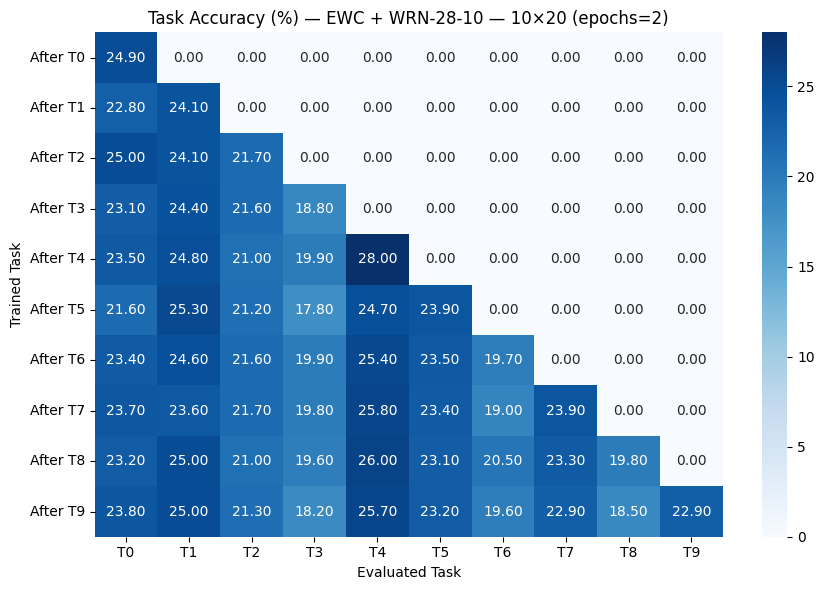

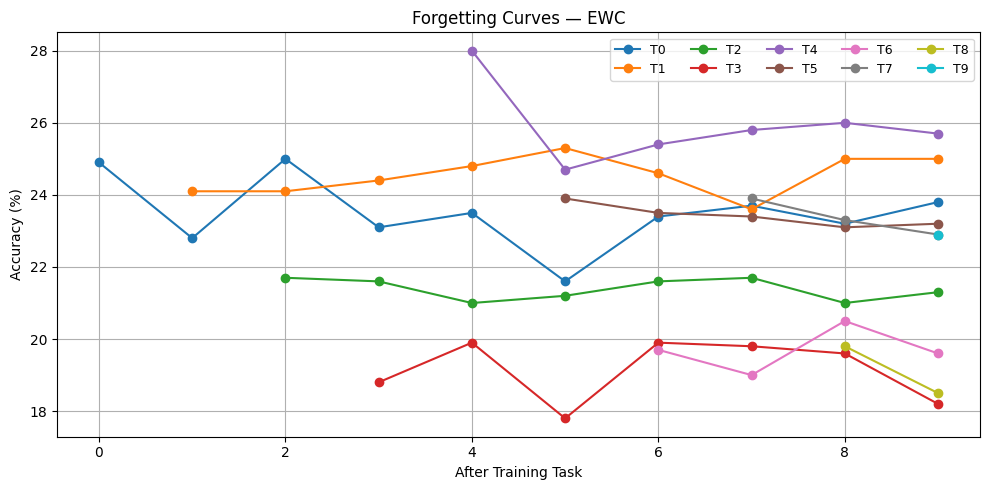

In [5]:
# =========================
# EWC on Split Tiny-ImageNet (10 tasks × 20 classes)
# Jupyter-ready, stable (no NaNs), full 10×10 matrix + forgetting curves
# =========================

import os, math, random, time
from pathlib import Path
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------
# Repro / Device
# -----------------------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------
# Point to your local dataset
# Example (Mac): DATA_ROOT = Path.home() / "data"
# The folder DATA_ROOT / "tiny-imagenet-200" must exist
# -----------------------
DATA_ROOT = Path.home() / "data"
TIN_ROOT  = DATA_ROOT / "tiny-imagenet-200"
assert TIN_ROOT.exists(), f"Not found: {TIN_ROOT}. Place tiny-imagenet-200/ there."

# -----------------------
# Class order & mapping (stable via wnids.txt)
# -----------------------
wnids_path = TIN_ROOT / "wnids.txt"
with open(wnids_path) as f:
    wnids = [w.strip() for w in f if w.strip()]
assert len(wnids) == 200
global_class_to_idx = {w:i for i,w in enumerate(wnids)}

# 10 tasks × 20 classes each
TASKS = [list(range(t*20, (t+1)*20)) for t in range(10)]

# -----------------------
# Transforms
# -----------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4802,0.4481,0.3975), std=(0.2770,0.2691,0.2821)),
])
test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4802,0.4481,0.3975), std=(0.2770,0.2691,0.2821)),
])

# -----------------------
# Minimal Tiny-ImageNet datasets
# -----------------------
class TinyImageNetTaskTrain(Dataset):
    def __init__(self, root: Path, class_indices, transform=None):
        self.root = root; self.transform = transform
        self.class_indices = class_indices
        self.wnids = [wnids[i] for i in class_indices]
        self.samples = []
        tr_root = self.root / "train"
        for gid, wn in zip(class_indices, self.wnids):
            img_dir = tr_root / wn / "images"
            for name in os.listdir(img_dir):
                if name.lower().endswith((".jpeg",".jpg",".png")):
                    self.samples.append((img_dir / name, gid))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        if self.transform: x = self.transform(x)
        return x, y

class TinyImageNetTaskVal(Dataset):
    def __init__(self, root: Path, class_indices, transform=None):
        self.root = root; self.transform = transform
        self.class_set = set(class_indices)
        self.samples = []
        img_dir = self.root / "val" / "images"
        ann = self.root / "val" / "val_annotations.txt"
        with open(ann) as f:
            for line in f:
                parts = line.strip().split("\t")
                if len(parts) >= 2:
                    fname, wn = parts[0], parts[1]
                    gid = global_class_to_idx[wn]
                    if gid in self.class_set:
                        self.samples.append((img_dir / fname, gid))
    def __len__(self): return len(self.samples)
    def __getitem__(self, i):
        p, y = self.samples[i]
        x = Image.open(p).convert("RGB")
        if self.transform: x = self.transform(x)
        return x, y

def make_loaders_for_classes(cls_list, batch_size=128, workers=0):
    tr = TinyImageNetTaskTrain(TIN_ROOT, cls_list, transform=train_transform)
    va = TinyImageNetTaskVal(TIN_ROOT, cls_list, transform=test_transform)
    trl = DataLoader(tr, batch_size=batch_size, shuffle=True,  num_workers=workers, pin_memory=True)
    val = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True)
    return trl, val

# -----------------------
# WRN-28-10 (CIFAR-style backbone with adaptive pool)
# -----------------------
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super().__init__()
        self.equalInOut = (in_planes == out_planes)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, 1, 1, bias=False)
        self.drop = dropRate
        self.short = None if self.equalInOut else nn.Conv2d(in_planes, out_planes, 1, stride, 0, bias=False)
    def forward(self, x):
        out = self.relu1(self.bn1(x)); out = self.conv1(out)
        out = self.relu2(self.bn2(out))
        if self.drop > 0: out = F.dropout(out, p=self.drop, training=self.training)
        out = self.conv2(out)
        return (x if self.equalInOut else self.short(x)) + out

class NetworkBlock(nn.Module):
    def __init__(self, n, in_planes, out_planes, block, stride, dropRate=0.0):
        super().__init__()
        layers=[]
        for i in range(n):
            s = stride if i==0 else 1
            layers.append(block(in_planes if i==0 else out_planes, out_planes, s, dropRate))
        self.layer = nn.Sequential(*layers)
    def forward(self, x): return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, depth=28, widen_factor=10, num_classes=200, dropRate=0.0):
        super().__init__()
        assert (depth-4)%6==0
        n = (depth-4)//6; k=widen_factor
        ch=[16,16*k,32*k,64*k]
        self.conv1 = nn.Conv2d(3,ch[0],3,1,1,bias=False)
        self.block1 = NetworkBlock(n,ch[0],ch[1],BasicBlock,1,dropRate)
        self.block2 = NetworkBlock(n,ch[1],ch[2],BasicBlock,2,dropRate)
        self.block3 = NetworkBlock(n,ch[2],ch[3],BasicBlock,2,dropRate)
        self.bn = nn.BatchNorm2d(ch[3]); self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(ch[3], num_classes); self.nC=ch[3]
        for m in self.modules():
            if isinstance(m, nn.Conv2d): nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d): nn.init.constant_(m.weight,1.0); nn.init.constant_(m.bias,0.0)
            elif isinstance(m, nn.Linear): nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5)); nn.init.constant_(m.bias,0.0)
    def forward(self, x):
        x=self.conv1(x); x=self.block1(x); x=self.block2(x); x=self.block3(x)
        x=self.relu(self.bn(x)); x=F.adaptive_avg_pool2d(x,1).view(-1,self.nC)
        return self.fc(x)

# -----------------------
# Masked CE / Accuracy (task-aware eval with single 200-way head)
# -----------------------
def masked_cross_entropy(logits, labels, class_list):
    idx_map = {c:i for i,c in enumerate(class_list)}
    new_y = torch.tensor([idx_map[int(l.item())] for l in labels], device=labels.device)
    mask = torch.tensor(class_list, device=logits.device)
    return F.cross_entropy(logits.index_select(1, mask), new_y)

@torch.no_grad()
def masked_accuracy(logits, labels, class_list):
    idx_map = {c:i for i,c in enumerate(class_list)}
    new_y = torch.tensor([idx_map[int(l.item())] for l in labels], device=labels.device)
    mask = torch.tensor(class_list, device=logits.device)
    preds = logits.index_select(1, mask).argmax(1)
    return (preds==new_y).float().mean().item()*100.0

# -----------------------
# Stable Online-EWC
#  - decayed Fisher
#  - Fisher normalization & clipping
#  - gradient clipping
# -----------------------
class EWC:
    def __init__(self, model, lambda_ewc=20.0, fisher_decay=0.9, fisher_clip=1.0, eps=1e-8):
        self.lambda_ewc = lambda_ewc
        self.fisher_decay = fisher_decay
        self.fisher_clip = fisher_clip
        self.eps = eps
        self.star = {}
        self.fisher = {n: torch.zeros_like(p, device=p.device) for n,p in model.named_parameters() if p.requires_grad}

    def consolidate(self, model, fisher_new):
        # decay old fisher and add new
        for n in self.fisher:
            self.fisher[n].mul_(self.fisher_decay).add_(fisher_new[n])
            # normalize per-parameter and clip
            m = self.fisher[n].abs().mean()
            if torch.isfinite(m) and m > 0:
                self.fisher[n].div_(m)
            self.fisher[n].clamp_(0, self.fisher_clip)
        # snapshot theta*
        self.star = {n: p.detach().clone() for n,p in model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        if not self.star: 
            return torch.tensor(0.0, device=device)
        reg = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad:
                d = p - self.star[n]
                reg = reg + (self.fisher[n] * d.pow(2) + self.eps).sum()
        return self.lambda_ewc * reg

def compute_fisher(model, dataloader, class_list, max_batches=100):
    model.eval()
    fisher = {n: torch.zeros_like(p, device=device) for n,p in model.named_parameters() if p.requires_grad}
    steps = 0
    for b,(x,y) in enumerate(dataloader):
        if b>=max_batches: break
        x,y = x.to(device), y.to(device)
        model.zero_grad(set_to_none=True)
        logits = model(x)
        loss = masked_cross_entropy(logits, y, class_list)
        if not torch.isfinite(loss): continue
        loss.backward()
        for n,p in model.named_parameters():
            if p.grad is not None:
                fisher[n] += p.grad.detach().pow(2)
        steps += 1
    for n in fisher:
        fisher[n] /= max(1, steps)
    return fisher

# -----------------------
# Train / Eval
# -----------------------
def train_task(model, loader, vloader, class_list, ewc_obj, epochs=3, lr=0.1, wd=5e-4, prefix=""):
    opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd, nesterov=True)
    # AMP off by default for CPU notebooks; enable on CUDA if desired
    use_amp = (device.type=="cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    for ep in range(1, epochs+1):
        model.train()
        seen = 0; sum_loss = 0.0; sum_acc = 0.0
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(x)
                ce = masked_cross_entropy(logits, y, class_list)
                reg = ewc_obj.penalty(model) if ewc_obj is not None else 0.0
                loss = ce + reg
            # finite-loss guard
            if not torch.isfinite(loss):
                continue
            scaler.scale(loss).backward()
            # gradient clipping for stability
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler.step(opt); scaler.update()

            bs = y.size(0); seen += bs
            sum_loss += loss.item()*bs
            sum_acc  += masked_accuracy(logits.detach(), y, class_list)*bs/100.0

        val = evaluate_task(model, vloader, class_list)
        print(f"{prefix}Epoch {ep:02d}: train_loss={sum_loss/max(1,seen):.4f} "
              f"train_acc={sum_acc/max(1,seen):.3f} | val_acc={val:.3f}")

def evaluate_task(model, loader, class_list):
    model.eval()
    s=0.0; n=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            s += masked_accuracy(logits, y, class_list)*y.size(0)/100.0
            n += y.size(0)
    return s/max(1,n)

# -----------------------
# Orchestrate 10 tasks
# -----------------------
BATCH_SIZE        = 32
WORKERS           = 0
EPOCHS_PER_TASK   = 2       # set 3–5 as you like
LR                = 0.001
WD                = 5e-4
LAMBDA_EWC        = 20.0
FISHER_DECAY      = 0.9     # < 1.0 = online EWC; helps prevent blow-up
FISHER_CLIP       = 1.0
FISHER_MAX_BATCHES= 100

# Build loaders
train_loaders, val_loaders = [], []
for t, cls_list in enumerate(TASKS):
    tr, va = make_loaders_for_classes(cls_list, batch_size=BATCH_SIZE, workers=WORKERS)
    train_loaders.append(tr); val_loaders.append(va)

# Model + EWC
model = WideResNet(depth=28, widen_factor=10, num_classes=200).to(device)
ewc   = EWC(model, lambda_ewc=LAMBDA_EWC, fisher_decay=FISHER_DECAY, fisher_clip=FISHER_CLIP)

# Acc matrix (rows: after training Tt, cols: eval Tk)
T = len(TASKS)
acc_matrix = np.zeros((T, T), dtype=np.float32)

def eval_on(k):
    return evaluate_task(model, val_loaders[k], TASKS[k]) * 100.0

for t in range(T):
    print(f"\n=== Train Task {t} (classes {TASKS[t][0]}–{TASKS[t][-1]}) "
          f"{'— EWC OFF' if t==0 else '— EWC ON'} ===")
    train_task(model, train_loaders[t], val_loaders[t], TASKS[t],
               ewc_obj=None if t==0 else ewc,
               epochs=EPOCHS_PER_TASK, lr=LR, wd=WD, prefix=f"[T{t}] ")

    # evaluate 0..t
    for k in range(t+1):
        acc = eval_on(k)
        acc_matrix[t,k] = acc
        print(f"[Eval] After Task {t} — T{k} Val acc = {acc:.2f}%")

    # Fisher & consolidate
    print(f"Computing Fisher on Task {t}…")
    fish = compute_fisher(model, train_loaders[t], TASKS[t], max_batches=FISHER_MAX_BATCHES)
    ewc.consolidate(model, fish)

# -----------------------
# Print snapshot & plots
# -----------------------
print("\n=== Retention snapshot (diagonal = last-task accuracies) ===")
for r in range(T):
    row = "  ".join(f"{acc_matrix[r,c]:5.2f}" if acc_matrix[r,c]>0 else "  --- " for c in range(T))
    print(f"After T{r}: {row}")

plt.figure(figsize=(9,6))
sns.heatmap(acc_matrix, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=[f"T{i}" for i in range(T)],
            yticklabels=[f"After T{i}" for i in range(T)])
plt.xlabel("Evaluated Task"); plt.ylabel("Trained Task")
plt.title(f"Task Accuracy (%) — EWC + WRN-28-10 — 10×20 (epochs={EPOCHS_PER_TASK})")
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
for k in range(T):
    curve = [acc_matrix[r,k] if r>=k else np.nan for r in range(T)]
    plt.plot(curve, marker='o', label=f"T{k}")
plt.xlabel("After Training Task"); plt.ylabel("Accuracy (%)")
plt.title("Forgetting Curves — EWC")
plt.grid(True); plt.legend(ncol=5, fontsize=9); plt.tight_layout(); plt.show()
